In [1]:
import csv
import glob
import os
import re

In [2]:
import matplotlib.pyplot as plt

In [3]:
from collections import defaultdict

In [4]:
gene_orth = defaultdict(set)
exon_orth = defaultdict(lambda: defaultdict(set))

In [5]:
for fp in glob.iglob("data/homology/genes/*.csv"):
    base = os.path.basename(fp).removesuffix(".csv")
    _, name = base.split("_", maxsplit=1)
    
    with open(fp, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        
        for row in reader:
            # If `gene` (the human gene) is in the file, it
            # has at least some evidence of orthology in the comparison
            # species.
            gene, *_ = row
            gene_orth[gene].add(name)

In [6]:
with open("../data/homology/exons/exons.csv", 'r') as f:
    reader = csv.DictReader(f)

    for row in reader:
        hsap_type, hsap_exon = row.pop('hsap_exon').split("=")

        hsap_gene = row.pop('hsap_gene')
        hsap_func = row.pop('hsap_gene_biotype')

        if hsap_func != "protein_coding":
            continue

        chrom, *pos = re.split('[:-]', hsap_exon)
        beg, end, strand = map(int, pos)

        hsap_exon = f"{chrom}:{beg}-{end}:{strand}"
        exon_orth[hsap_exon]['homo_sapiens'] = hsap_type

        for name, exon in row.items():
            if exon == "-":
                exon_orth[hsap_exon][name] = "N"
            else:
                exon_type, _ = exon.split("=")
                exon_orth[hsap_exon][name] = exon_type

In [7]:
N = {'new_gene': 0, 'new_exon': 0, 'new_ss': 0}

In [8]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, meta_exon, p, ss, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue

        exon_type, exon = meta_exon.split("=")
        if exon not in exon_orth \
                or exon_type != "FE":
            continue

        pos_group = pos_group.split(";")
        neg_group = neg_group.split(";")

        pos_types = set([exon_orth[exon][name] for name in pos_group]) - {'N'}
        neg_types = set([exon_orth[exon][name] for name in neg_group]) - {'N'}

        # If `exon in exon_orth`, we also know the exon had an alignment in 1+
        # species, so we're not counting cases where there's not a homolog in
        # the negative group because the human exon failed to align.
        if len(neg_types) == 0:
            abbv_names = list()

            # BioMart abbreviates the species' names.
            for name in neg_group:
                *pre, suf = name.split("_")
                abbv_names.append("".join([p[0] for p in pre]) + suf)

            if set([abbv in gene_orth[gene] for abbv in abbv_names]) == {False}:
                # We have no evidence of a gene homolog.
                N['new_gene'] += 1
            else:
                # We have evidence of a gene homolog but not
                # an exon homolog.
                N['new_exon'] += 1

            continue

        if "FE" in neg_types:
            # We have evidence of an FE homolog (and, so, a
            # gene homolog is implied), but no evidence of a SS.
            N['new_ss'] += 1

In [9]:
t = N['new_ss'] + N['new_exon'] + N['new_gene']
percentages = [N['new_ss'] / t, N['new_exon'] /  t, N['new_gene'] / t]

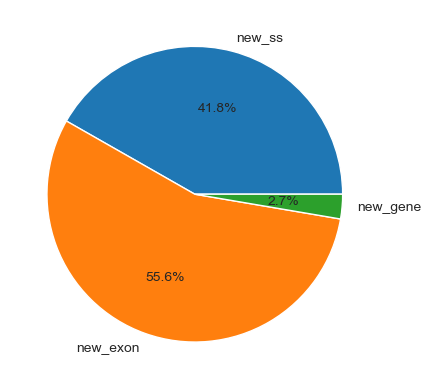

In [11]:
_ = plt.pie(percentages, labels=['new_ss', 'new_exon', 'new_gene'], autopct='%1.1f%%')
# plt.savefig("figs/main3c.pdf")